# Pipelines

In [28]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
# import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/loan_prediction')

In [31]:
%load_ext google.colab.data_table
%load_ext tensorboard

import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance


from loan_prediction.config import prep_train, split_train, split_test, \
                                split_test_y_true, final_model, log_dir
from loan_prediction.custom_funcs import data_transformer, remove_outliers, \
                                    plot_confusion_matrix, onehot_enc, transform_train


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
# %tensorboard --logdir "/content/gdrive/MyDrive/Colab Notebooks/loan_prediction/notebooks/logs"

## Preppocessing pipeline training 

In [33]:
def int64_to_int16(df):

    int64_cols = df.loc[:, df.dtypes == np.int64].columns
    int64_cols = list(int64_cols.drop('SBA_Appv'))
    for col in int64_cols:
        df[col] = df[col].astype(np.int16)
    
    return df

In [34]:
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(split_train)
df = data_transformer(df)
df = remove_outliers(df, 3)
df = int64_to_int16(df)

df_test = pd.concat([pd.read_csv(split_test), pd.read_csv(split_test_y_true)], axis=1)
df_test = data_transformer(df_test)

label = 'Default'

In [35]:
df.shape

(634293, 17)

In [36]:
df.dtypes

name_end                object
State                   object
same_state                bool
NAICS                   object
Term                     int16
NoEmp                    int16
CreateJob                int16
RetainedJob              int16
FranchiseCode            int16
UrbanRural               int16
RevLineCr                int16
LowDoc                   int16
Default                   bool
SBA_Appv                 int64
Recession                 bool
days_to_disbursement     int16
disbursement_year        int16
dtype: object

In [37]:
X = df.drop(label, 1)
y = df[label]

X_test = df_test.drop(label, 1)
y_test = df_test[label]

In [38]:
prep_pipeline = Pipeline([           
    ('onehot_enc', FunctionTransformer(onehot_enc)),
    ('feat_selection', SelectFromModel(XGBClassifier(), threshold=0.0001)),
    ('standard_scaler', StandardScaler())
])

In [39]:
prep_pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('onehot_enc',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function onehot_enc at 0x7f4bc5468170>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=0.5,
                                                         booster='gbtree',
                                                         colsample_bylevel=1,
                                                         colsample_bynode=1,
                                                         colsample_byt...
                                                         min_child_weight=1,
                                                         missing=None,
                                                         n_estimators=100,
        

In [40]:
oversampler = SMOTE(random_state=42)
oversampler_name = str(oversampler.__class__).split('.')[-1]

In [41]:
X = prep_pipeline.transform(X)
X, y = transform_train(X, y, oversampler)

X_test = prep_pipeline.transform(X_test)

Before: False    515223
True     119070
Name: Default, dtype: int64
After: True     515223
False    515223
dtype: int64


## Neural Network 

In [42]:
%load_ext tensorboard

import time 


from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow.math import confusion_matrix

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [43]:
NAME = f'Final {int(time.time())}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir / {NAME}

print(NAME)

Final 1616227437


In [44]:
def create_model():

    model = Sequential()

    model.add(layers.Dense(80, activation='relu'))
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

    return model


In [45]:
model = create_model()

In [46]:
epochs = 10
model.fit(X, y,
          epochs=epochs,
          callbacks=[tensorboard_callback])

Epoch 1/10
32202/32202 [==============================] - 63s 2ms/step - loss: 0.3590 - accuracy: 0.8474 - auc: 0.9193
Epoch 2/10
32202/32202 [==============================] - 62s 2ms/step - loss: 0.2877 - accuracy: 0.8827 - auc: 0.9491
Epoch 3/10
32202/32202 [==============================] - 61s 2ms/step - loss: 0.2671 - accuracy: 0.8931 - auc: 0.9560
Epoch 4/10
32202/32202 [==============================] - 62s 2ms/step - loss: 0.2550 - accuracy: 0.8976 - auc: 0.9599
Epoch 5/10
32202/32202 [==============================] - 62s 2ms/step - loss: 0.2481 - accuracy: 0.9000 - auc: 0.9620
Epoch 6/10
32202/32202 [==============================] - 62s 2ms/step - loss: 0.2423 - accuracy: 0.9026 - auc: 0.9637
Epoch 7/10
32202/32202 [==============================] - 65s 2ms/step - loss: 0.2387 - accuracy: 0.9042 - auc: 0.9647
Epoch 8/10
32202/32202 [==============================] - 63s 2ms/step - loss: 0.2358 - accuracy: 0.9052 - auc: 0.9655
Epoch 9/10
32202/32202 [========================

In [47]:
y_pred = model.predict_classes(X_test)
y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

Final 1616227437


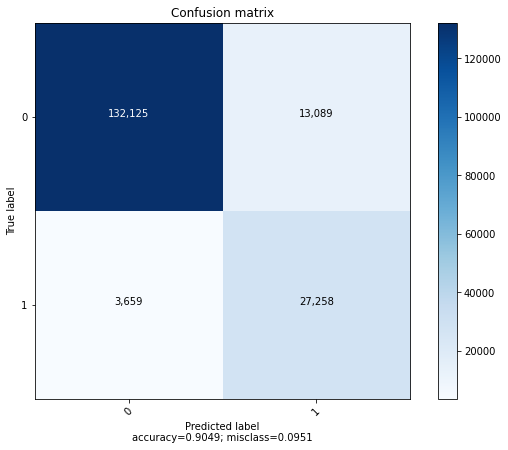

In [48]:
print(NAME)
cm = confusion_matrix(y_test, y_pred)
cm = np.array(cm)

target_names = [0, 1]
plot_confusion_matrix(cm, target_names, normalize=False)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.91      0.94    145214
        True       0.68      0.88      0.76     30917

    accuracy                           0.90    176131
   macro avg       0.82      0.90      0.85    176131
weighted avg       0.92      0.90      0.91    176131



In [51]:
# model.save(final_model)